# Logistic Regression

In this notebook, we'll see how to build and evaluate logistic regression models using the _statsmodels_ library.

We'll be working with a data set consisting of a sample of 200 subjects who were part of a study on survival of patients following admission to an adult intensive care unit. The goal of the study was to develop a logistic regression model to predict the probability of survival to hospital discharge of these patients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
icu = pd.read_csv('../data/icu.csv')

In [4]:
icu.head()

,ID,STA,AGE,SEX,RACE,SER,CAN,CRN,INF,CPR,...,HRA,PRE,TYP,FRA,PO2,PH,PCO,BIC,CRE,LOC
0,552,0,16,0,1,1,0,0,0,0,...,140,0,1,1,0,0,0,0,0,0
1,102,0,16,1,1,0,0,0,0,0,...,111,0,1,0,0,0,0,0,0,0
2,837,0,17,1,3,0,0,0,0,0,...,140,0,1,0,0,0,0,0,0,0
3,863,0,17,0,3,1,0,0,0,0,...,78,0,1,0,0,0,0,0,0,0
4,829,0,17,0,1,1,0,0,0,0,...,78,0,1,1,0,0,0,0,0,0


The variables are as follows:

|Variable | Description | Codes/Values|
|---|---|---|
| ID | Identification Code | ID Number|
| STA | Vital Status | 0 = Lived<br /> 1 = Died |
| AGE | Age | Years |
| SEX | Sex | 0 = Male<br /> 1 = Female | 
| RACE | Race | 1 = White<br />2 = Black<br />3 = Other |
| SER | Service at ICU Admission | 0 = Medical<br />1 = Surgical |
| CAN | Cancer Part of Present Problem | 0 = No<br />1 = Yes |
| CRN | History of Chronic Renal Failure | 0 = No<br />1 = Yes |
| INF | Infection Probable at ICU Admission | 0 = No<br />1 = Yes |
| CPR | CPR Prior to ICU Admission | 0 = No<br />1 = Yes |
| SYS | Systolic Blood Pressure at ICU Admission | mm Hg |
| HRA | Heart Rate at ICU Admission | Beats/min |
| PRE | Previous Admission to an ICU Within 6 Months | 0 = No<br />1 = Yes |
| TYP | Type of Admission | 0 = Elective<br />1 = Emergency |
| FRA | Long Bone, Multiple, Neck, Single Area, or Hip Fracture | 0 = No<br />1 = Yes |
| PO2 | PO2 from Initial Blood Gases | 0: $>$60<br />1: $\leq$ 60 |
| PH | PH from Initial Blood Gases | 0: $\geq$ 7.25<br />1: $<$7.25 |
| PCO | PCO2 from Initial Blood Gases | 0: $\leq$ 45<br />1: $>$45 |
| BIC | Bicarbonate from Initial Blood Gases | 0: $\geq$ 18<br />1: $<$ 18 |
| CRE | Creatinine from Initial Blood Gases | 0: $\leq$2.0<br />1: $>$2.0 |
| LOC | Level of Consciousness at ICU Admission | 0 = No Coma or Deep Stupor<br />1 = Deep Stupor<br />2 = Coma |

We can start by looking at the relationship between age and status.

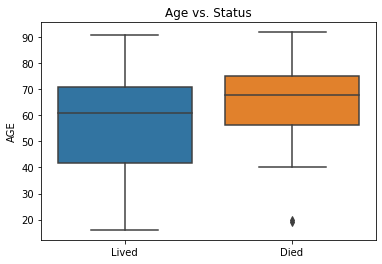

In [5]:
sns.boxplot(data = icu, y = 'AGE', x = 'STA')
plt.xticks([0,1], ['Lived', 'Died'])
plt.xlabel('')
plt.title('Age vs. Status');

In order to fit our model, we'll again be using the statsmodels's formula api.

In [6]:
import statsmodels.formula.api as sm

We can fit a logistic regression model similarly to how we fit a linear regression model, but this time using `logit`.

Again, we use a formula specifying `target ~ predictor(s)`.

In [7]:
logreg = sm.logit('STA ~ AGE', data = icu).fit()

Optimization terminated successfully.
         Current function value: 0.480766
         Iterations 6


The summary method shows coefficient estimates and confidence intervals.

In [8]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    STA   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                 0.03924
Time:                        12:35:12   Log-Likelihood:                -96.153
converged:                       True   LL-Null:                       -100.08
Covariance Type:            nonrobust   LLR p-value:                  0.005069
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0585      0.696     -4.394      0.000      -4.423      -1.694
AGE            0.0275      0.011      2.607      0.009       0.007       0.048
==============================================================================
"""

We can get predicted probabilities using the `predict` method and passing in a DataFrame with the expected variables.

In [1]:
logreg.predict(icu)

NameError: name 'logreg' is not defined

### Logistic Regression Inference

Let's run a few hypothesis tests for logistic regression.

**Question:** Is the coefficient for SEX statistically significant, after controlling for AGE?

**Null Hypothesis:** $\beta_{sex} = 0$

**Alternative Hypothesis:** $\beta_{sex} \neq 0$

Like we did for linear regression, we need to fit a full model containing all variables of interest and then a reduced model satisfying the null hypothesis.

In [26]:
logreg_full = sm.logit('STA ~ AGE + SEX', data = icu).fit()
logreg_reduced = sm.logit('STA ~ AGE', data = icu).fit()

Optimization terminated successfully.
         Current function value: 0.480764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480766
         Iterations 6


We can access the log-likelihood values using the `llf` attribute.

In [27]:
logreg_full.llf

-96.15272714024452

In [28]:
logreg_reduced.llf

-96.15319019186063

We do see a higher log-likelihood for the full model, but the question is whether that improvement is statistically significant.

The test statistic we use is 

$$G^2 = -2(\text{log likelihood of reduced model} - \text{log likelihood of full model})$$

In [29]:
G2 = -2 * (logreg_reduced.llf - logreg_full.llf)
G2

0.0009261032322172014

Under the null hypothesis, this statistic will follow a chi-square distribution with degrees of freedom equal to the difference in parameters fit between the two models.

We can import the chi-square distribution from scipy stats.

In [30]:
from scipy.stats import chi2

To find the degrees of freedom, we can use the `df_model` attribute.

In [31]:
df = logreg_full.df_model - logreg_reduced.df_model

And finally, to find the p-value, we can use the `sf` method, which stands for "survival function". This tells the probability of seeing a value at least as large as the one specified. This gives the $p$-value for our test.

In [32]:
chi2.sf(G2, df = df)

0.9757225688020016

**Conclusion:** Do not reject the null hypothesis. There is not enough evidence to conclude that the effect of sex is statistically significant, after controlling for age.

We can condense what we did into one cell.

In [33]:
logreg_full = sm.logit('STA ~ AGE + SEX', data = icu).fit()
logreg_reduced = sm.logit('STA ~ AGE', data = icu).fit()

G2 = -2 * (logreg_reduced.llf - logreg_full.llf)
df = logreg_full.df_model - logreg_reduced.df_model
print(f'p-value: {chi2.sf(G2, df = df)}')

Optimization terminated successfully.
         Current function value: 0.480764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480766
         Iterations 6
p-value: 0.9757225688020016


**Your Turn:** Is the effect of systolic blood pressure (SYS) significant, after controlling for age?

In [ ]:
# Your Code Here

**Questions:** Look at the coefficients for your model which includes AGE and SYS. How does the value of AGE affect the predicted probability? How does the value of SYS affect this probability?

### Generating Predictions

In [35]:
from nssstats.cm import cm_analysis
from sklearn.model_selection import train_test_split

If we want to evaluate how well our model does at making predictions, we need to first divide it into a training set and a test set.

For this, we'll use the `train_test_split` function from scikit-learn. We need to give the full dataset, the proportion that we want to split off as a test set, and we can also specify if we want to stratify our split.

Stratifying will ensure that the proportion of the stratify variable is the same in the training data and in the test data.

In [41]:
icu_train, icu_test = train_test_split(icu, test_size = 0.25, stratify = icu['STA'], random_state = 321)

We'll fit a model using several of our predictor variables.

In [42]:
logreg_pred = sm.logit('STA ~ AGE + SYS + SER + TYP + PO2 + PH + PCO + BIC + CRE + C(LOC)',
                       data = icu_train).fit()

         Current function value: 0.325574
         Iterations: 35


/home/michael/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Once we have fit our model, we can generate predictions on the test data using the `predict` method.

In [43]:
y_pred = logreg_pred.predict(icu_test) > 0.5

We can use the crosstab function if we want to see how well the predicted values matche up to the true labels.

In [44]:
pd.crosstab(icu_test['STA'], y_pred)

col_0,False,True
STA,,
0,38,2
1,5,5


There's also a cm_analysis helper function if we want another way to visualize the results.

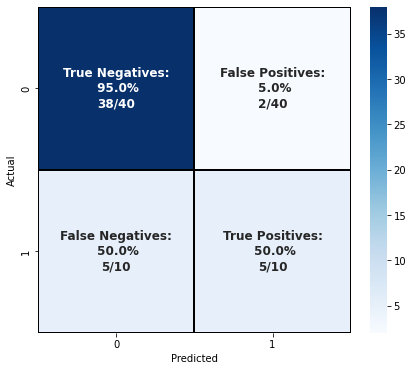

In [45]:
cm_analysis(icu_test['STA'], y_pred, labels = [0, 1], figsize = (7,6))